
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2023**

---

# Trabajo práctico entregable - Parte 2

In [1]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from seaborn_qqplot import pplot
from scipy.stats import norm
from scipy import stats
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

sns.set_context('talk')

## Lectura del dataset

En la notebook 00 se explican los detalles de la siguiente sección.

In [8]:
url = 'https://raw.githubusercontent.com/DiploDatos/AnalisisyVisualizacion/master/sysarmy_survey_2022_processed.csv'
df = pd.read_csv(url)

In [9]:
df[:3]

,work_country,work_province,work_dedication,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,numero,salary_in_usd,salary_last_dollar_value,salary_pay_cripto,...,profile_studies_level_state,profile_career,profile_university,profile_boot_camp,profile_boot_camp_carrer,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,profile_age,profile_gender
0,Argentina,Catamarca,Full-Time,Staff (planta permanente),300000.0,245000.0,True,NaN,NaN,NaN,...,Completo,Licenciatura en redes y comunicación de datos,UP - Universidad de Palermo,NaN,NaN,NaN,NaN,NaN,35,Varón Cis
1,Argentina,Chaco,Full-Time,Remoto (empresa de otro país),900000.0,850000.0,True,Cobro todo el salario en dólares,300,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,Varón Cis
2,Argentina,Chaco,Full-Time,Staff (planta permanente),120000.0,115000.0,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,Varón Cis


In [10]:
df.profile_gender.unique()

array(['Varón Cis', 'Varón cis', 'Mujer Cis', 'Mujer', 'Varón Trans',
       'Queer', 'No binarie', 'Mujer cis', 'Mujer Trans', 'mujer', 'Gay',
       'Fluido', 'Bigénero', 'Femenino'], dtype=object)

In [11]:
df.loc[:,'profile_g'] = df.profile_gender.replace({'Varón Cis': 'Varón cis','Mujer': 'Mujer cis','Mujer Cis': 'Mujer cis','Femenino': 'Mujer cis','mujer': 'Mujer cis','Mujer':'Mujer cis','Queer':'Diversidades','Varón Trans':'Diversidades','No binarie':'Diversidades','Mujer Trans':'Diversidades','Fluido':'Diversidades','Bigénero':'Diversidades','Gay':'Diversidades'}).fillna(False)

In [12]:
df.profile_g.unique()

array(['Varón cis', 'Mujer cis', 'Diversidades'], dtype=object)

In [13]:
df[['profile_g', 'salary_monthly_NETO']].groupby('profile_g').describe()

salary_monthly_NETO                                               \
                           count           mean            std  min       25%   
profile_g                                                                       
Diversidades                98.0  261873.543041  356719.368150  0.0   90500.0   
Mujer cis                  929.0  188903.430667  184912.713803  0.0   91000.0   
Varón cis                 4331.0  296252.343889  433193.328154  0.0  125000.0   

                                              
                   50%       75%         max  
profile_g                                     
Diversidades  174448.5  262250.0   1950000.0  
Mujer cis     160000.0  237003.0   1878500.0  
Varón cis     212146.0  307988.0  15000000.0

In [14]:
df[df.salary_monthly_NETO > 1000]\
  [['profile_g', 'salary_monthly_NETO']].groupby('profile_g').describe()

salary_monthly_NETO                                        \
                           count           mean            std     min   
profile_g                                                                
Diversidades                85.0  301914.321765  367031.242344  2800.0   
Mujer cis                  806.0  217708.858077  182050.554847  1400.0   
Varón cis                 3975.0  322777.029197  442612.347688  1100.0   

                                                         
                   25%       50%        75%         max  
profile_g                                                
Diversidades  125000.0  190000.0  280000.00   1950000.0  
Mujer cis     116000.0  180000.0  248193.75   1878500.0  
Varón cis     147106.5  225000.0  322827.50  15000000.0

In [15]:
# complete here if you want to include more columns
relevant_columns = ['Trabajo de','tools_programming_languages','salary_monthly_BRUTO','salary_monthly_NETO','profile_years_experience']

#Revisamos cuales son las posiciones más relevantes. Para ello agrupamos la columna "Trabajo de", vemos cuantos registros posee
#y calculamos la proporción de los encuestados que quedan agrupados en cada categoría.
#CRITERIO: se seleccionan los primeros 15 puestos que acumulan el 80% de los casos
cl = pysqldf("""
                SELECT  df.'Trabajo de' as position,
                        COUNT(df.'Trabajo de') as count,
                        COUNT(df.'Trabajo de') *100/(SELECT COUNT(df.'Trabajo de') FROM df) as share
                FROM df
                GROUP BY position
                ORDER BY count DESC
                LIMIT 15;
        
        """)
top_80 = cl.position.unique()


#Se filtra por aquellas posiciones que representan el 80% de los casos 
df1 = df[relevant_columns]
df1 = df1[df1['Trabajo de'].isin(top_80)]

#Se conservan registros cuya diferencia entre salario bruto y neto sea positiva.
#Por otro lado, se eliminan registros cuyo valor de salario sea menor a 10.000 pesos
df1 = pysqldf("""
              SELECT df.'Trabajo de',
                     df.tools_programming_languages,
                     df.salary_monthly_BRUTO,
                     df.salary_monthly_NETO,
                     df.profile_gender,
                     df.profile_years_experience
                     
              FROM df
              
              WHERE df.salary_monthly_BRUTO-salary_monthly_NETO>0
              AND df.salary_monthly_BRUTO > 10000
              AND df.salary_monthly_NETO > 10000;
        """)

In [16]:
alpha = 0.05

In [17]:
is_man = df.profile_g == 'Varón cis'
df1 = df1[(df1['salary_monthly_NETO'] >= 99600) & (df1['salary_monthly_NETO']<=651780.4)]
groupA = df1[(df1.salary_monthly_NETO > 1000) & is_man].salary_monthly_NETO
groupB = df1[(df1.salary_monthly_NETO > 1000) & ~is_man].salary_monthly_NETO

C:\Users\Elesefoo\AppData\Local\Temp\ipykernel_4488\2277130656.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  groupA = df1[(df1.salary_monthly_NETO > 1000) & is_man].salary_monthly_NETO
C:\Users\Elesefoo\AppData\Local\Temp\ipykernel_4488\2277130656.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  groupB = df1[(df1.salary_monthly_NETO > 1000) & ~is_man].salary_monthly_NETO


## Ejercicio 1: Estimación

**Consigna:**  Calcular una estimación puntual y un intervalo de confianza de nivel (1-alpha) para la resta entre la media del salario Neto para Hombres menos la media del salario Neto para otros géneros(diferencia de las medias entre el grupoA y grupoB). 
¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

Text(0.5, 1.0, 'GroupB')

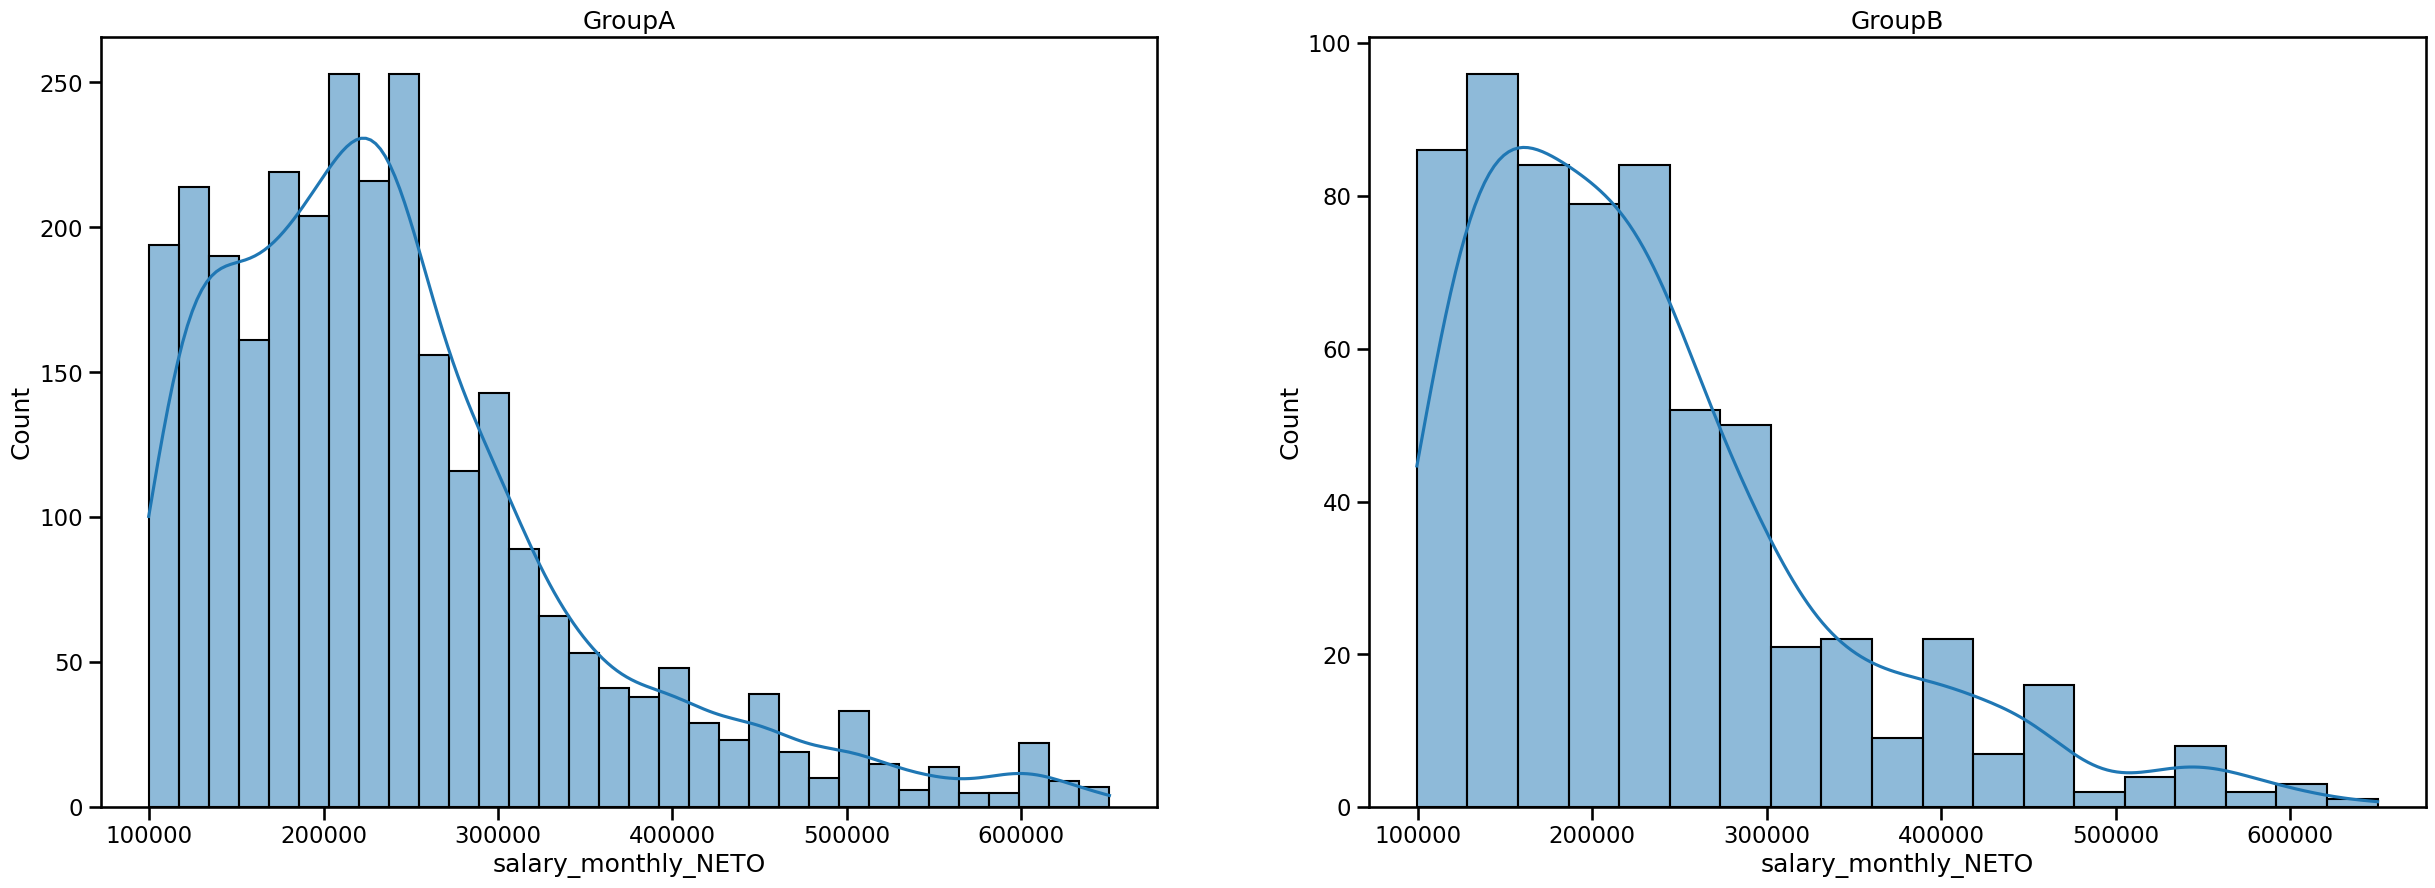

In [18]:
#histograma de los dos grupos
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
sns.histplot(data=groupA,ax=axs[0],kde= True).set_title('GroupA')
sns.histplot(data=groupB,ax=axs[1],kde= True).set_title('GroupB')

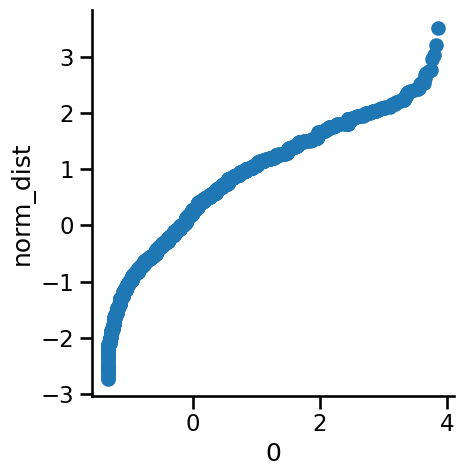

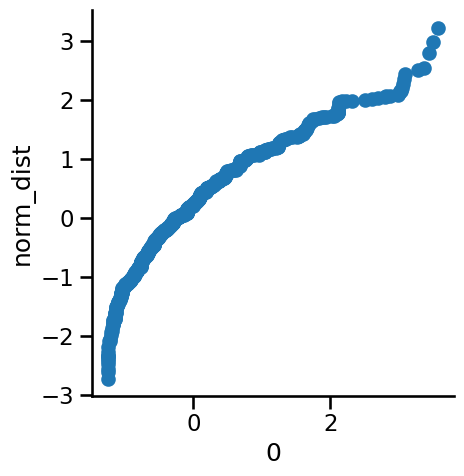

In [19]:
##qqplot vs distribución normal
#normalización de los datos
#1.reshape a Group a un array 2D
groupA_reshape=groupA.values.reshape(-1,1)
groupB_reshape=groupB.values.reshape(-1,1)
#2.normalización con resta y división por varianza muestral, usando StandardScaler
groupA_norm=StandardScaler().fit_transform(groupA_reshape)
groupB_norm=StandardScaler().fit_transform(groupB_reshape)
#Graficamos los qqplot de los datos normalizados vs distrib. normal
#1.pplot requiere un dataframe y volvemos los Group noramlizados (que son numpy array) a un DF de pandas.
groupA_norm_df=pd.DataFrame(groupA_norm)#.rename(columns={ groupA_norm_df.columns[0]: "GroupA" }, inplace = True)
groupB_norm_df=pd.DataFrame(groupB_norm)
#2.graficamos qqplot
pplot(groupA_norm_df,x=groupA_norm_df.columns[0],y=norm,kind='qq',height=5)
pplot(groupB_norm_df,x=groupB_norm_df.columns[0],y=norm,kind='qq',height=5)

In [20]:
# separar los datos por género
#groupA = df.loc[df['profile_gender'] == 'Varón cis']['salary_monthly_NETO']
#groupB = df.loc[df['profile_gender'] != 'Varón cis']['salary_monthly_NETO']

# calcular la diferencia de medias
mean_diff = groupA.mean() - groupB.mean()

# estimar el error estándar de la diferencia de medias
n_A, n_B = len(groupA), len(groupB)
std_A, std_B = groupA.std(), groupB.std()
std_diff = np.sqrt((std_A**2/n_A) + (std_B**2/n_B))

# establecer el nivel de confianza y el valor de alfa
conf_level = 0.95
alpha = 1 - conf_level

# calcular el intervalo de confianza para la diferencia de medias
t_value = stats.t.ppf(1 - alpha/2, n_A + n_B - 2)
lower_bound = mean_diff - t_value * std_diff
upper_bound = mean_diff + t_value * std_diff

# imprimir los resultados
print("Estimación puntual de la diferencia de medias:", mean_diff)
print(f"Intervalo de confianza al {conf_level*100:.1f}%: ({lower_bound:.2f}, {upper_bound:.2f})")

Estimación puntual de la diferencia de medias: 11606.883402921987
Intervalo de confianza al 95.0%: (2705.10, 20508.67)


**Estimación puntual de la diferencia de medias: 11606.88
Intervalo de confianza al 95.0%: (2705.10, 20508.67)**

El resultado muestra la estimación puntual de la diferencia de medias y el intervalo de confianza al 95% para esta diferencia.

En cuanto a la relación entre este intervalo de confianza y el test de hipótesis, podemos usar el intervalo de confianza para realizar una prueba de hipótesis para la diferencia de medias. Si el intervalo de confianza no incluye cero, podemos rechazar la hipótesis nula de que no hay diferencia entre las medias y afirmar que hay una diferencia significativa entre los salarios netos de los hombres y los demás géneros. De lo contrario, no podemos rechazar la hipótesis nula y afirmar que no hay suficiente evidencia para sugerir una diferencia significativa. El test de hipótesis se realiza de manera similar al intervalo de confianza, pero la decisión se toma basada en si el valor observado está dentro o fuera del intervalo de confianza

## Ejercicio 2: Test de hipótesis



### 2.1 Formalización

Describir formalmente los distintos componentes de un test de hipótesis para comprobar si la distribución de los salarios es distinta entre los grupos A y B.

**Hipótesis Nula**

$H_0:$ No hay diferencia entre los valores medios de la distribución de los salarios de los grupos A y B

**Hipótesis Alternativa**

$H_1:$ Hay diferencia entre los valores medios de la distribución de los salarios de los grupos A y B.

**Estadístico (Pivote)**
  * Identificar el estadístico
  * Escribir qué distribución tiene bajo $H_0$


Hipótesis nula (H0): No hay diferencia entre las distribuciones de los salarios en los grupos A y B. H0: fA(x) = fB(x)
Hipótesis alternativa (HA): Hay una diferencia significativa entre las distribuciones de los salarios en los grupos A y B. HA: fA(x) ≠ fB(x)

Estadístico (pivote): El estadístico es una función de los datos de la muestra que se utiliza para evaluar la evidencia en contra de la hipótesis nula. En este caso, se puede utilizar el estadístico de prueba t para comparar las medias de los salarios en los grupos A y B. Bajo la hipótesis nula, el estadístico de prueba sigue una distribución t de Student con grados de libertad igual a (nA + nB - 2), donde nA y nB son los tamaños de la muestra en los grupos A y B, respectivamente.

Nivel de significancia (α): El nivel de significancia es la probabilidad de rechazar la hipótesis nula cuando es verdadera. Es una medida de la probabilidad de que se cometa un error de Tipo I. Normalmente se utiliza un nivel de significancia del 5% (α=0,05) o del 1% (α=0,01).

Valor p: El valor p es la probabilidad de obtener un valor del estadístico de prueba al menos tan extremo como el observado, bajo la hipótesis nula. Si el valor p es menor que el nivel de significancia, se rechaza la hipótesis nula en favor de la hipótesis alternativa.

Región de rechazo: La región de rechazo es el conjunto de valores del estadístico de prueba que son lo suficientemente extremos para rechazar la hipótesis nula en un nivel de significancia dado.

Decisión: En función del valor p y el nivel de significancia, se toma la decisión de rechazar o no la hipótesis nula. Si el valor p es menor que el nivel de significancia, se rechaza la hipótesis nula en favor de la hipótesis alternativa. En caso contrario, no se puede rechazar la hipótesis nula y se concluye que no hay suficiente evidencia para afirmar que hay una diferencia significativa entre las distribuciones de los salarios en los grupos A y B.

### 2.2 P-valor

1. Calcule el p-valor y decida si rechazar o no la hipótesis nula.
2. Interprete el resultado.

Links útiles:
* [Test de hipótesis usando scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
* [Test de Welch](http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html)



**Tenemos 2 resultados posibles a la hora de sacar una conclusion con respecto al P-Valor.**

$\alpha$ = 0.05

Si P-Valor $\leq$ $\alpha/2$ o P-Valor $\geq$  1 - $\alpha/2$, Rechazamos la hipotesis nula.

In [21]:
t_statistic, p_value = stats.ttest_ind(groupA, groupB, equal_var = False)

# establecer el nivel de significancia y el valor de alfa
sign_level = 0.05
alpha = sign_level / 2  # prueba de dos colas

# imprimir los resultados
print("Estadístico de prueba t:", t_statistic)
print("Valor p:", p_value)
if p_value < alpha or p_value > 1 - alpha:
    print("Rechazamos la hipótesis nula y afirmamos que hay una diferencia significativa.")
else:
    print("No podemos rechazar la hipótesis nula y afirmar que no hay suficiente evidencia para sugerir una diferencia significativa.")

Estadístico de prueba t: 2.5564382598484223
Valor p: 0.010725607790039176
Rechazamos la hipótesis nula y afirmamos que hay una diferencia significativa.


In [22]:
### Estos resultados son sin limitar los datos.

#Estadístico de prueba t: 8.471264605702991
#Valor p: 7.049291897481084e-17
#Rechazamos la hipótesis nula y afirmamos que hay una diferencia significativa.

### [Opcional] 2.3 Potencia del test

Nuestra muestra, ¿era lo suficientemente grande para detectar si existe o no una diferencia entre los grupos?

1. Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.
2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

[Documentación](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html)

NOTA: este análisis debería hacerse ANTES de recolectar los datos.

In [23]:
from statsmodels.stats.power import tt_ind_solve_power

In [24]:
effect_size = (groupA.mean() - groupB.mean()) / groupB.std()
nobs1 = None  #- What we want to know
alpha = 0.05
ratio = len(groupB) / len(groupA)

In [34]:
power= 0.8
po_80 = tt_ind_solve_power(effect_size=effect_size, nobs1 = nobs1, alpha=alpha,power=power,
                   ratio=ratio, alternative = 'two-sided')
nob2_80 = ratio * po_80
(po_80, nob2_80)

(3442.445673465405, 771.8701717666374)

In [35]:
power = 0.9
po_90 = tt_ind_solve_power(effect_size=effect_size, nobs1 = nobs1, alpha=alpha, power=power,
                   ratio=ratio, alternative = 'two-sided')
nob2_90 = ratio * po_90
(po_90, nob2_90)

(4607.935939048304, 1033.1980929077165)

In [36]:
power = 0.95
po_95 = tt_ind_solve_power(effect_size=effect_size, nobs1 = nobs1, alpha=alpha, power=power,
                   ratio=ratio, alternative = 'two-sided')
nob2_95 = ratio * po_95
(po_95, nob2_95)

(5698.34324263852, 1277.690803193689)

**Para una potencia de test de 0.8, necesitamos que:**
1. Nuestra muestra 1 (groupA) tenga un tamaño de 3442 elementos.
2. Nuestra muestra 2 (groupB) tenga un tamaño de 772 elementos.

**Para una potencia de test de 0.9, necesitamos que:**
1. Nuestra muestra 1 (groupA) tenga un tamaño de 4608 elementos.
2. Nuestra muestra 2 (groupB) tenga un tamaño de 1033 elementos.

**Para una potencia de test de 0.95, necesitamos que:**
1. Nuestra muestra 1 (groupA) tenga un tamaño de 5698 elementos.
2. Nuestra muestra 2 (groupB) tenga un tamaño de 1278 elementos.

#### Vemos que mientras mas aumente el poder del estadisco, mas grande debe ser la muestra.

2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

* En definitiva, el poder estadístico representa la probabilidad de rechazar la hipótesis nula cuando es realmente falsa. Es decir, representa la capacidad de un test para detectar como estadísticamente significativas diferencias o asociaciones de una magnitud determinada.
<br><br>

* Nuestra muestra es representativa de la tendencia general, con un poder estadistico de 0.80. Los tamaños muestrales deberían ser de aproximadamente 3442. Pero con un poder estadistico mayor, no alcanza el tamaño de nuestra muestra. Para una potencia de 90 necesitas una muestra de al menos 4607 y para una de 95, de 5698
<br>
* Si bien los datos son generales a un potencia del 0.8 y podria usarse en juicio como prueba. Habria que considerar el caso de cada empresa en particular

## Ejercicio 3: Comunicación y visualización

**Consigna:** Seleccionen un resultado que les parezca relevante a partir de alguno de los ejercicios del entregable. Diseñe e implemente una comunicación en base a este mensaje, en un archivo PDF.

Elija las palabras y visualización más adecuada para que la comunicación sea entendible, efectiva y se dapte a UNA de las siguientes situaciones:

1. Una sección en un artículo de difusión a presentar como parte de una organización sin fines de lucro.
No más de 1 página A4 (o dos si los gráficos son muy grandes).
  1. Ejemplo: Alguna de las secciones [Los ecosistemas de emprendimiento de América Latina y el Caribe frente al COVID-19: Impactos, necesidades y recomendaciones](https://publications.iadb.org/es/los-ecosistemas-de-emprendimiento-de-america-latina-y-el-caribe-frente-al-covid-19-impactos-necesidades-y-recomendaciones), por ejemplo la sección *2.2. Reacciones de los emprendedores*.
  2. Ejemplo: Alguna de las secciones de [The state of gender pay gap in 2021](https://www.payscale.com/data/gender-pay-gap?tk=carousel-ps-rc-job)
  3. Puntos clave: 
    1. Simpleza de los gráficos.
    2. Comunicación en lenguaje simple a personas que no son necesariamente expertos de dominio.
    2. Selección de UNA oración sobre la que se hace énfasis.
    3. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

2. Una publicación científica o reporte técnico interno. No más de una página A4:
  2. Ejemplo: La sección de resultados de [IZA DP No. 12914: The Impact of a Minimum Wage Change on the Distribution of Wages and Household Income](https://www.iza.org/publications/dp/12914/the-impact-of-a-minimum-wage-change-on-the-distribution-of-wages-and-household-income).
  2. Ejemplo: Alguna de las secciones de [Temporary reduction in daily global CO2 emissions during the COVID-19 forced confinement](https://www.nature.com/articles/s41558-020-0797-x)
  3. Puntos clave:
    3. Nivel de detalle técnico requerido. Es necesario justificar la validez del análisis.
    4. La idea presentada puede ser más compleja. Pueden asumir que la audiencia tiene conocimiento técnico y va a analizar las visualizaciones en detalle. 
    5. Pueden presentar más en detalle las limitaciones del análisis (significancia estadística, etc.)
    2. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

3. Un tweet (o post de LinkedIn) para la cuenta de su empresa consultora que hace análisis de datos. El objetivo es promocionar un análisis de datos abiertos que van a incluir en su portfolio:
  1. Ejemplo: [Comparación vacunas covid](https://twitter.com/infobeautiful/status/1381577746527236098?s=20)
  2. Ejemplo: [Tweet del BID](https://twitter.com/el_BID/status/1388508583944507396?s=20). Lo valioso de este tweet es que usaron un único número para transmitir un mensaje. Puede ser algo así, o con un gráfico muy simple.
  3. Ejemplo: [Cambio climático](https://twitter.com/UNFCCC/status/1387732156190011394?s=20) Es un muy buen ejemplo, excepto que el gráfico no se lee nada y hay que entrar a la publicación original.
  3. Ejemplo: [¿Cuánto están los programadores en las empresas?](https://www.linkedin.com/posts/denis-rothman-0b034043_tech-career-work-activity-6793861923269054464-gS6y) (No verificamos la veracidad o seriedad de la fuente).
  4. Puntos clave:
    1. Su audiencia no va a mirar la visualización por más de unos segundos, y no tiene conocimiento técnico.
  3. Tienen que incluir además una *breve* descripción de cómo obtuvieron los datos que están presentando, que no entraría en el tweet.
